In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Load the dataset
data = pd.read_csv('fer2013.csv')

# The dataset has a 'pixels' column containing image data in a string format and an 'emotion' column for labels.
# The 'pixels' are converted from string to 48x48 numpy arrays (images) and stored as float32 for neural network compatibility.
data['pixels'] = data['pixels'].apply(lambda x: np.fromstring(x, sep=' ').reshape(48, 48, 1).astype('float32'))

# Split the dataset into features and labels
X = data['pixels'].tolist()
y = data['emotion'].values

# Define the class names corresponding to the emotion labels in the dataset.
class_names = [ #list of available emotions in the dataset
    "Angry",
    "Disgust",
    "Fear",
    "Happy",
    "Sad",
    "Surprize",
    "Neutral"
]

# Define image size for resizing, number of classes, and batch size for training.

img_size=224
num_classes = 7
batch_size = 256

# Stratify split the dataset into training, validation, and test sets.
# Stratify ensures that each set has a similar proportion of each class as in the original dataset.

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, stratify=y_train_val, random_state=42)


In [2]:
def preprocess_image(image):
    image = tf.image.resize(image, [img_size, img_size])  # Resize to 48x48
    image /= 255.0  # Normalize pixel values
    image = tf.image.grayscale_to_rgb(image)  # Convert grayscale to RGB
    return image

def augment(image, label):
    # Data augmentation (random flip, rotation, etc.)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    return image, label

# Convert to TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Apply preprocessing and augmentation
train_dataset = train_dataset.map(lambda x, y: (preprocess_image(x), y)).map(augment).shuffle(1000).batch(batch_size)
val_dataset = val_dataset.map(lambda x, y: (preprocess_image(x), y)).batch(32)
test_dataset = test_dataset.map(lambda x, y: (preprocess_image(x), y)).batch(32)


2024-01-18 13:40:52.373779: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-18 13:40:54.170008: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-01-18 13:40:54.170054: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37424 MB memory:  -> device: 0, name: A100 80GB PCIe, pci bus id: 0000:17:00.0, compute capability: 8.0
2024-01-18 13:40:54.172655: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH 

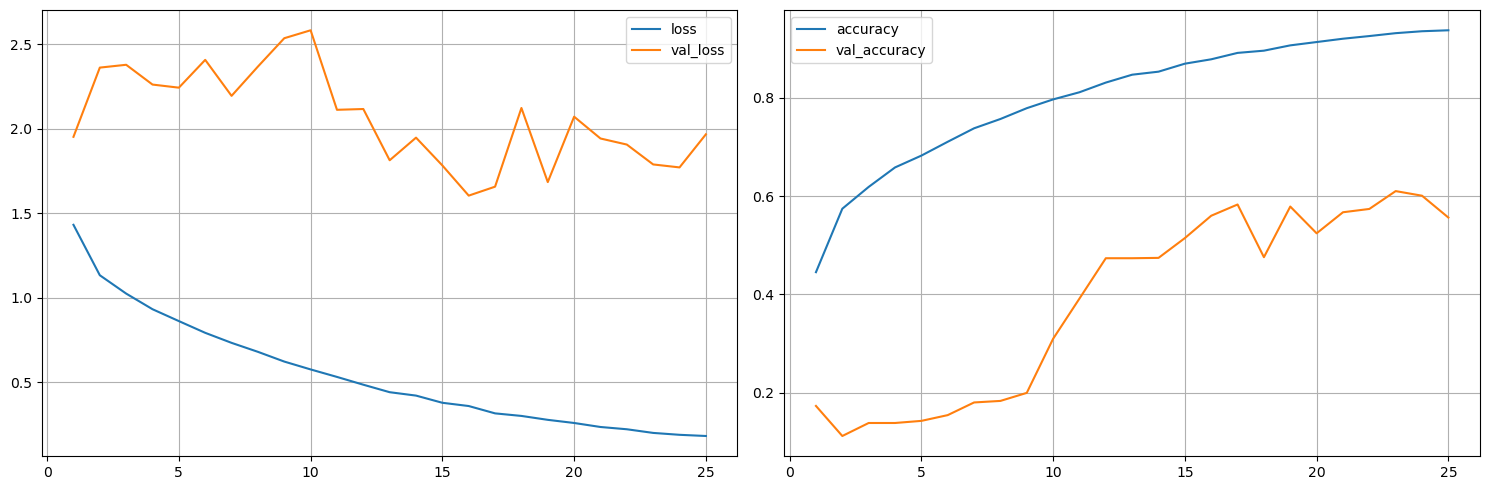

79/79 [==============================] - 80s 975ms/step - loss: 0.1838 - accuracy: 0.9375 - val_loss: 1.9665 - val_accuracy: 0.5563


In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.models import Model
from plot_callback import PlotLearning


# Define the number of classes
num_classes = len(set(y))

# ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_size, img_size, 3)))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model_resnet = Model(inputs=base_model.input, outputs=predictions)

initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model_resnet.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the ResNet model
model_resnet.fit(train_dataset, validation_data=val_dataset, epochs=25,callbacks=[PlotLearning()])


Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.42      0.48       991
           1       0.54      0.46      0.50       109
           2       0.48      0.26      0.33      1024
           3       0.89      0.72      0.79      1798
           4       0.51      0.38      0.44      1216
           5       0.48      0.89      0.62       800
           6       0.44      0.70      0.54      1240

    accuracy                           0.57      7178
   macro avg       0.56      0.55      0.53      7178
weighted avg       0.59      0.57      0.56      7178

Confusion Matrix:


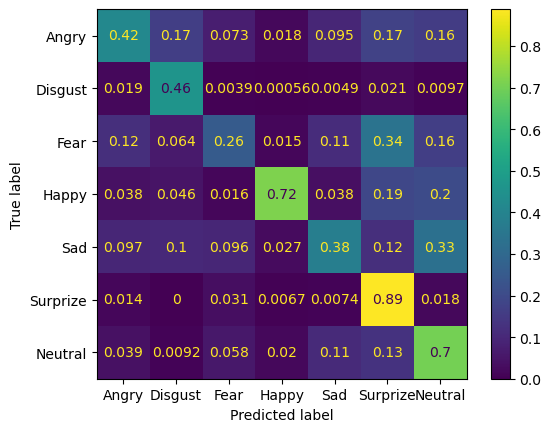

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Predict on the test dataset
y_pred = model_resnet.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes,labels=[0, 1, 2, 3, 4, 5, 6]))

# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_classes)
cm = cm / cm.astype(np.float64).sum(axis=1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)

disp.plot()
plt.show()


# Fixing with Class Imbalance

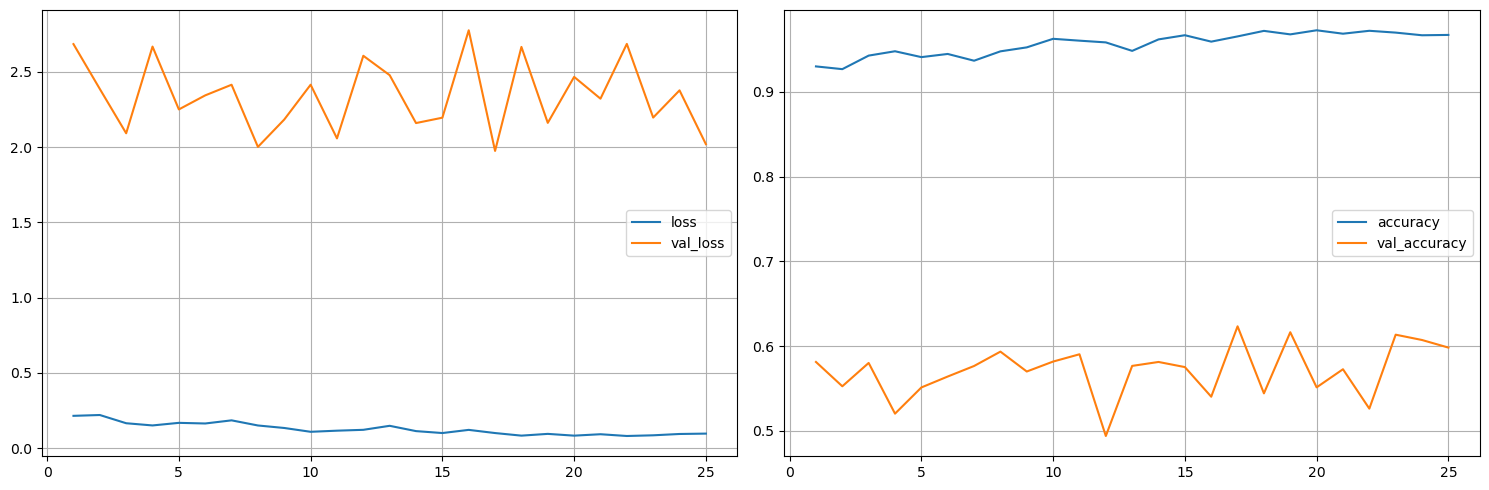

79/79 [==============================] - 54s 650ms/step - loss: 0.0959 - accuracy: 0.9670 - val_loss: 2.0202 - val_accuracy: 0.5983


In [11]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))


initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Use these class weights in model training
model_resnet.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_resnet.fit(train_dataset, validation_data=val_dataset, epochs=25, class_weight=class_weight_dict,callbacks=[PlotLearning()])


Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.51      0.53       991
           1       0.38      0.55      0.45       109
           2       0.46      0.36      0.40      1024
           3       0.82      0.80      0.81      1798
           4       0.53      0.47      0.50      1216
           5       0.53      0.90      0.66       800
           6       0.59      0.54      0.56      1240

    accuracy                           0.60      7178
   macro avg       0.55      0.59      0.56      7178
weighted avg       0.60      0.60      0.60      7178

Confusion Matrix:


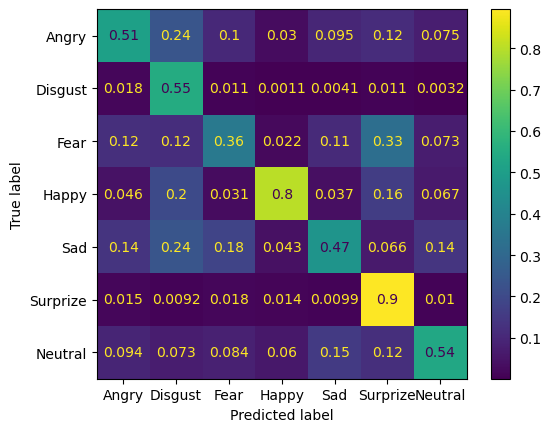

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict on the test dataset
y_pred = model_resnet.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes,labels=[0, 1, 2, 3, 4, 5, 6]))

# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_classes)
cm = cm / cm.astype(np.float64).sum(axis=1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)

disp.plot()
plt.show()
